In [1]:
# dans ce code on cherche à définir plusieurs zones à une échéance fixe
# import sklearn.metrics
import numpy as np
import glob
import xarray as xr 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib
# import pandas as pd
import time
import glob
import sys, os
import string
from pathlib import Path # pour windows 
sys.path.insert(0, os.path.abspath('./lib'))

from lib import read_xarray, find_neighbours, conversion
# from lib import hss,precision,far,f1, pod
from lib import create_combination_subzones, create_nc_mask_NSEO
from lib import group_masks_size, get_optimal_subzone, select_group_mask, get_WME_legend, get_not_included_masks
from lib import calculate_distance


# lecture du mask

In [2]:
# 29 : Finistère (185), 34: Hérault (235 combi), 38: Isère (80 combi), 41: Loi-et-cher (27)
# date   = '2019110400'
# date   = '2019121200'
# # date   = '2019122100'
# dep_id = '38'#'29'#'41' #'38'#

dep_id = '38'#'29'#'41' #'38'#
date   = '2020012600'
echeance = 44
name = 'compas' # pour agreger le temps sensible
windows = True 
score_zonage = 'hss'
# echeance = 10

mask_sympo = True
mask_geographique = False

dir_fig = 'C:\\Users\\mary\\Desktop\\stageemi\\figures\\'

# mask_sympo = False
# mask_geographique = True

if mask_sympo and not mask_geographique: 
    t1 = time.time()
    if windows : 
#         print('windows')
        fname_out =  Path(r'C:\\Users\\mary\\Desktop\\stageemi\\zones_sympo_multiples\\'+ dep_id+'_mask_zones_sympos.nc')
    else :         
        fname_out = '/home/mrpa/borderiesm/stageEMI/Codes/StageEMI/Masques_netcdf/ZONE_SYMPO_MULTIPLE/'+ dep_id+'_mask_zones_sympos.nc'
    if not os.path.exists(fname_out): 
        dir_mask = '/home/mrpa/borderiesm/stageEMI/Codes/StageEMI/Masques_netcdf/ZONE_SYMPO/'
        list_subzones = glob.glob(dir_mask + dep_id +'*.nc')
        n_subzones = len(list_subzones)  # nombre de zones sympos initiales
        lst_subzones = [zone[-7:-3] for zone in list_subzones]
        ds_mask = create_combination_subzones(dir_mask,dep_id,lst_subzones,fname_out,degre5=True) 
    else: 
        print(fname_out)
        ds_mask = read_xarray(fname_out)
    print(time.time() - t1)
    
if mask_geographique and not mask_sympo: 
    dir_mask  = '/home/mrpa/borderiesm/stageEMI/Codes/stageemi/stageemi/GeoData/nc_departement/'
    if   dep_id == '38': dep = 'FRK24'
    elif dep_id == '41': dep = 'FRB05'
    elif dep_id == "34": dep = 'FRJ13'
    elif dep_id == '29': dep = "FRH02"
    else: 
        print('remplir la bonne valeur pour le dep')
        sys.exit()
        
    dep_file  = dir_mask + dep +'.nc' 
    fname_out = '/home/mrpa/borderiesm/stageEMI/Codes/StageEMI/Masques_netcdf/ZONE_SYMPO_MULTIPLE/'+ dep_id+'_'+dep+'_mask_NSEO.nc'

    if not os.path.exists(fname_out):
        ds_mask = create_nc_mask_NSEO(dep_file,fname_out)
    else:
        print('fichier existe pas')
#         ds_mask = read_xarray(fname_out) 

print(ds_mask.id.values.size)

C:\Users\mary\Desktop\stageemi\zones_sympo_multiples\38_mask_zones_sympos.nc
0.19949126243591309
151


# lecture champs arome et groupement de certains temps sensibles 

In [3]:
if windows: 
    dir_in = 'C:\\Users\\mary\\Desktop\\stageemi\\WWMF\\' 
    fname = Path(dir_in +  date+'0000__PG0PAROME__'+'WWMF'+'__EURW1S100______GRILLE____0_48_1__SOL____GRIB2.nc')
else:    
    dir_in = '/scratch/labia/lepapeb/StageEMI/WWMF/'
    fname  = dir_in + date+'0000__PG0PAROME__'+'WWMF'+'__EURW1S100______GRILLE____0_48_1__SOL____GRIB2.nc'
    
ds     = read_xarray(fname)
ds.latitude.values = ds.latitude.values[::-1]
if mask_sympo and not mask_geographique: 
    ds2plot = ds.isel(step=echeance) * ds_mask.mask.sel(id='departement') 
if mask_geographique and not mask_sympo: 
    ds2plot = ds.isel(step=echeance) * ds_mask.mask.sel(id="mask") 
# ds2plot.unknown[ind] = 0  
for name in ['compas','compas_asym']:
    ds_WME = conversion(ds2plot,name) 

file_CodesWWMF = '../../utils/CodesWWMF.csv'
cible_list,legend_list = get_WME_legend(file_CodesWWMF, ds_WME)
print('avant:')
print(cible_list,legend_list)
for var_name in ['wme_arr']:#,'wme_asym_arr']:
    # on regroupe 'Très nuageux/Couvert' et 'Nuageux'
    ds_WME[var_name].values[(ds_WME[var_name].values == 2) 
                          + ((ds_WME[var_name].values == 3) )] = 2

    # on regroupe ensemble neige (10) et neige faible (7)
    ds_WME[var_name].values[(ds_WME[var_name].values == 7) 
                          + ((ds_WME[var_name].values == 10) )] = 10

    # on regroupe ensemble pluie (8) et pluie faible (6)
    ds_WME[var_name].values[(ds_WME[var_name].values == 6) 
                          + ((ds_WME[var_name].values == 8) )] = 8

    # on regroupe ensemble qlqs averses (12) et averses (14), et qlqs averses de neige (13)
    ds_WME[var_name].values[(ds_WME[var_name].values == 12) + (ds_WME[var_name].values == 13)
                          + ((ds_WME[var_name].values == 14) )] = 14

    # on regroupe ensemble averses Orageuses (16) et Orages  (18)
    ds_WME[var_name].values[(ds_WME[var_name].values == 16) + ((ds_WME[var_name].values == 18) )] = 18

del(ds,ds2plot)
# ds_WME.wme_arr.plot.imshow()

# on regarde les codes 
cible_list,legend_list = get_WME_legend(file_CodesWWMF, ds_WME)
print(cible_list,legend_list)

avant:
[ 3.  4.  6.  7. 10. 12. 13.] ['Très nuageux/Couvert', 'Brume/Brouillard/Grisaille', 'Pluie faible', 'Neige faible', 'Neige', 'Quelques averses', 'Quelques averses de neige']
[ 2.  4.  8. 10. 14.] ['Nuageux', 'Brume/Brouillard/Grisaille', 'Pluie', 'Neige', 'Averses']


# on selectionne les zones pour chaque departements

In [4]:
nsubzonesMax = 6
listCible    = cible_list[::-1]

listMasksNew = ds_mask.id.values # on commence avec l'ensemble des masks

# liste de zones sympos initiales (pour checker à la fin si oui ou non on a une info sur toutes les zones)
list_zones_sympos_initiales = [zone for zone in ds_mask.id.values if len(zone) == 4]

nsubzones    = 0
zones_cibles = {}
score_zones_cibles = {}
if len(listCible) == 0 : # si un département a le même temps sensible partout
    zones_cibles[listCible[0]] = 'departement'
else: 
    for icible,cible in enumerate(listCible):
        if nsubzones > nsubzonesMax: 
            print('nombre de sous-zones trop grand')
            break 
        if nsubzones >1: 
            # pour éviter que departement soit selectionné alors que des sous-zones de departement ont déjà été selectionnées.
            listMasksNew = [element for element in listMasksNew if element !='departement']
        if len(listMasksNew)>60:
            #  on regroupe les masks selon leur taille
            groupe1,groupe2,groupe3,taille1,taille2  = group_masks_size(listMasksNew,ds_mask)
            # on selectionne le groupement de zones qui match l'objet météo
            groupe_mask_select = select_group_mask(ds_WME,cible,groupe1,groupe2,groupe3,taille1,taille2)
        else: 
            # on considère l'ensemble des masks
            groupe_mask_select = ds_mask.mask.sel(id=listMasksNew)
        # on selectionne la zone optimale (selon le score souhaité)
#         print(groupe_mask_select.id.values)
        zones_optimales, scores_zones_optimales = get_optimal_subzone(ds_WME, groupe_mask_select,cible)
        score_zones_cibles[cible] = scores_zones_optimales[score_zonage]
        
        """
            Check sur le critère d'homogénéité, car s'il est trop bas -> pas de zones existantes qui caractérise le phénoméne cible
        """
        if score_zones_cibles[cible]< 0 :
            print('pas de zones homogène pour {}'.format(cible))
            print(score_zones_cibles[cible])
            print()
            continue
        else : 
            zones_cibles[cible] = zones_optimales[score_zonage]
            nsubzones +=1
        print(cible,zones_cibles[cible],score_zones_cibles[cible])

        '''
            on check que la somme des zones n'est pas deja egale au departement
        '''
        if  nsubzones== 1 : 
            ds_temp  = ds_mask.sel(id=zones_cibles[cible]).mask.copy()
        else: 
            ds_temp.values[(ds_temp.values == 1) + (ds_mask.sel(id=zones_cibles[cible]).mask.values ==1) ] = 1

        somme = np.sum((ds_temp.values == 1)&( ds_mask.sel(id='departement').mask.values== 1))
        tailleDep = np.sum( ds_mask.sel(id='departement').mask.values== 1)
        if somme == tailleDep: 
            print('on a atteint la taille du departement')
            break
        listMasksNew, lst_mask_included = get_not_included_masks(ds_mask.mask.sel(id=zones_optimales[score_zonage])
                                        ,listMasksNew,ds_mask,flag_strictly_included=False)

    '''
        on vérifie que toutes les zones du département sont dans les zones sympos
    '''
    list_zones_select = [zones_cibles[cible] for cible in zones_cibles.keys()]
    zones_restantes = []
    for zone_sympo in list_zones_sympos_initiales:
        n = 0
        for zone_select in list_zones_select: 
            if zone_sympo in zone_select:
                n+=1
        if n == 0 : 
            zones_restantes.append(zone_sympo)
    if len(zones_restantes) > 0: 
        print('zones restantes:',zones_restantes)
    else:
        print('toutes les zones sont bien décrites')
        
print(zones_cibles)    

3207.0 6292.0
objet dans groupe 1
14.0 3805 0.2674579275808247
2908.0 6078.0
objet dans groupe 1
10.0 3801+3802 0.6469550224094083
8.0 3804+3807+3808 0.41587897140111457
4.0 3806 0.033902871292954044
2.0 3803 0.11039827792516424
on a atteint la taille du departement
toutes les zones sont bien décrites
{14.0: '3805', 10.0: '3801+3802', 8.0: '3804+3807+3808', 4.0: '3806', 2.0: '3803'}


# pour brancher l'agrégation 

In [5]:
# name = "compas"
# temps_compas = {}
# for cible in zones_cibles.keys():
#     zone_select = zones_cibles[cible] 
#     ds_zone = ds_WME * ds_mask.mask.sel(id=zone_select)#ds_WME.wme_arr.where(ds_mask.mask.sel(id=zone).values==1,drop=True)
#     ds_zone.wme_arr.values[ds_zone.wme_arr.values == 0] = np.nan
#     ds = calculate_distance(ds_zone,name)
#     print(zone_select,cible,ds.attrs[name])
#     temps_compas[zone_select] = ds.attrs[name] 
# # dist_w[0]=np.asarray([np.sum(ds[w].isel(step=istep)) for iw,w in enumerate(list_w)])
        

In [6]:
# sys.exit()
temps_agrege = {}
for name in ['compas','compas_asym']:
    print(name)
    temps_agrege[name] = {}
#     ds_w1 = conversion(ds_WME,name)
    for cible in zones_cibles.keys():
        zone_select = zones_cibles[cible] 
        ds_zone = ds_WME * ds_mask.mask.sel(id=zone_select)#ds_WME.wme_arr.where(ds_mask.mask.sel(id=zone).values==1,drop=True)
        if name == 'compas':
            var_name = "wme_arr"
        if name == 'agat':
            var_name="w1_arr" 
        if name == "compas_asym":
            var_name="wme_asym_arr"
        if name == 'agat_asym':
            var_name="w1_asym_arr"
        ds_zone[var_name].values[ds_zone[var_name].values == 0] = np.nan        
        ds = calculate_distance(ds_zone,name)
        temps_agrege[zone_select] = ds.attrs[name]
        print(zone_select,cible,ds.attrs[name])   
    print('')

compas
3805 14.0 14
3801+3802 10.0 10
3804+3807+3808 8.0 8
3806 4.0 14
3803 2.0 14

compas_asym
3805 14.0 13
3801+3802 10.0 7
3804+3807+3808 8.0 6
3806 4.0 3
3803 2.0 6



# plot des zones selectionnées 

KeyError: '3805'

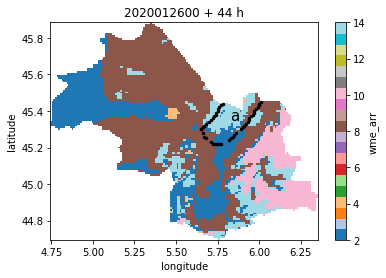

In [7]:
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

X,Y = np.meshgrid( ds_mask.longitude.values,ds_mask.latitude.values)
listMasks = [ds_mask.sel(id=id_ref) for id_ref in list_zones_sympos_initiales]

legende = string.ascii_lowercase
patches = []
fig,ax = plt.subplots(nrows=1,ncols =1)
ds_WME.wme_arr.plot.imshow(ax = ax,cmap=matplotlib.cm.tab20)
ax.set_title(date+' + {} h'.format(echeance))
# print(zones_cibles)
for icible,cible in enumerate(zones_cibles): #['3801+3802']:#, '3806']:#zones_cibles:
    zone_select = zones_cibles[cible] 
    mask_ref = ds_mask.sel(id = zone_select)

    list_neighbours = find_neighbours(mask_ref,listMasks)
    lst_mask_not_included, lst_mask_included = get_not_included_masks(mask_ref.mask, list_neighbours,ds_mask,flag_strictly_included=True)
    for neighbours in lst_mask_not_included:
        ind = np.where((mask_ref.mask.values == 1) & (ds_mask.sel(id=neighbours).mask.values == 1))
        ax.scatter(X[ind],Y[ind],color='k',s=6)
    
    # ajout de la legende
    indice_mask_ref = np.where(mask_ref.mask.values == 1)
    ax.text(X[indice_mask_ref].mean(),Y[indice_mask_ref].mean(),s=legende[icible],color='k',fontsize=15)
    label = zone_select +': '+ legend_list[::-1][icible] + ' ({})'.format(cible)\
            + ' Compas:{},'.format(temps_agrege['compas'][zone_select])\
            + ' Compas Asym:{}'.format(temps_agrege['compas'][zone_select])
    #        + ' Agat:{}'.format(temps_agat[zone_select])
#     patches.append(mpatches.Patch(label = legende[icible],marker='${}$'.format(legende[icible])))
    patches.append(mlines.Line2D([],[],label = label,marker='${}$'.format(legende[icible]),color='black'))


fig.legend(handles=patches,bbox_to_anchor=(1.05, 0.5), loc='center left',labelspacing =2,fontsize = 16)
fig.tight_layout()
fname_fig = dir_fig + 'zonage\\compas_compas_asym\\zonage_'+dep_id+date+'_'+str(echeance)+'.png'
print(fname_fig)
fig.savefig(fname_fig,dpi=400,bbox_inches='tight')
plt.clf()
plt.close('all')



# idem mais avec les zones sympos

In [ ]:
sys.exit()
name = "compas"
temps_compas_ref = {}
for zone_select in list_zones_sympos_initiales:
#     print(zone_select)
    ds_zone = ds_WME * ds_mask.mask.sel(id=zone_select)#ds_WME.wme_arr.where(ds_mask.mask.sel(id=zone).values==1,drop=True)
    ds_zone.wme_arr.values[ds_zone.wme_arr.values == 0] = np.nan
    ds = calculate_distance(ds_zone,name)
#     print(zone_select,cible,ds.attrs[name])
    temps_compas_ref[zone_select] = ds.attrs[name] 

In [ ]:
legende = string.ascii_lowercase
patches = []
fig,ax = plt.subplots(nrows=1,ncols =1)
ds_WME.wme_arr.plot.imshow(ax = ax,cmap=matplotlib.cm.tab20)
ax.set_title(date+' + {} h'.format(echeance))
# print(zones_cibles)

for icible,zone_select in enumerate(list_zones_sympos_initiales): #['3801+3802']:#, '3806']:#zones_cibles:
    mask_ref = ds_mask.sel(id = zone_select)

    list_neighbours = find_neighbours(mask_ref,listMasks)
    lst_mask_not_included, lst_mask_included = get_not_included_masks(mask_ref.mask, list_neighbours,ds_mask,flag_strictly_included=True)
#     print(zone_select,cible)
#     print(lst_mask_not_included)

    for neighbours in lst_mask_not_included:
        ind = np.where((mask_ref.mask.values == 1) & (ds_mask.sel(id=neighbours).mask.values == 1))
        ax.scatter(X[ind],Y[ind],color='k',s=6)
    
    # ajout de la legende
    indice_mask_ref = np.where(mask_ref.mask.values == 1)
    ax.text(X[indice_mask_ref].mean(),Y[indice_mask_ref].mean(),s=legende[icible],color='k',fontsize=15)
    label = zone_select +': ' + ' Compas:{},'.format(temps_compas_ref[zone_select])#\
#             + ' Agat:{}'.format(temps_agat[zone_select])
#     patches.append(mpatches.Patch(label = legende[icible],marker='${}$'.format(legende[icible])))
    patches.append(mlines.Line2D([],[],label = label,marker='${}$'.format(legende[icible]),color='black'))
fig.legend(handles=patches,bbox_to_anchor=(1.05, 0.5), loc='center left',labelspacing =2,fontsize = 16,ncol=2)
fig.tight_layout()
fig.savefig(dir_fig + 'zonage\\zonage_ref_'+dep_id+date+'_'+str(echeance)+'.png',dpi=400,bbox_inches='tight')
plt.clf()
plt.close('all')